In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

Import data, produce test and train splits, then fit the holt-winters model to the train set and evaluate forecasted values against testing set

In [2]:
passenger_data = pd.read_csv('/content/airline_passengers.csv', index_col='Month', parse_dates=True)

In [3]:
passenger_data.index.freq = 'MS'
passenger_data.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
passenger_data.tail()

,Thousands of Passengers
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


In [5]:
train_data = passenger_data.iloc[:109]
test_data = passenger_data.iloc[108:]

In [6]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
fitted_model = ExponentialSmoothing(train_data['Thousands of Passengers'], trend='mul',
                                    seasonal='mul', seasonal_periods=12).fit()

In [8]:
test_predictions = fitted_model.forecast(36)

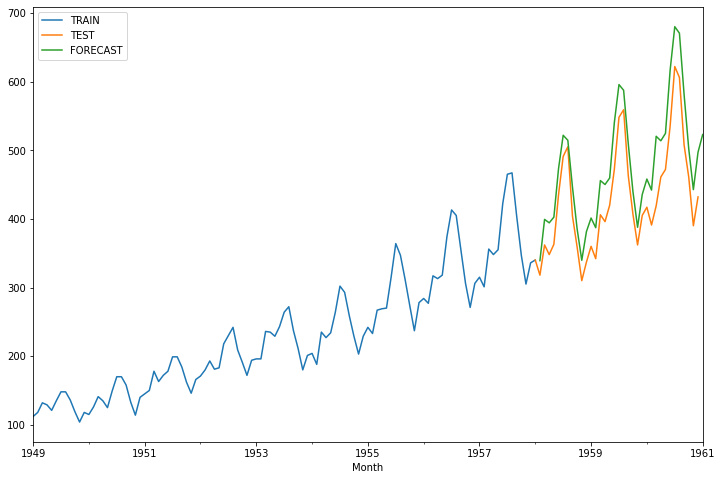

In [9]:
train_data['Thousands of Passengers'].plot(legend=True, label='TRAIN', figsize=(12, 8))
test_data['Thousands of Passengers'].plot(legend=True, label='TEST')
test_predictions.plot(legend=True, label='FORECAST')

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [11]:
test_data.describe()

,Thousands of Passengers
count,36.000000
mean,428.500000
std,79.329152
min,310.000000
25%,362.000000
50%,412.000000
75%,472.000000
max,622.000000


Compare error calculations to standard deviation to understand how well model fits to test set

In [12]:
np.sqrt(mean_squared_error(test_data, test_predictions))

74.92943823976594

In [13]:
mean_absolute_error(test_data, test_predictions)

63.03138491847624

Refit model on entire dataset for forecasting

In [14]:
final_model = ExponentialSmoothing(passenger_data['Thousands of Passengers'], trend='mul', seasonal='mul', seasonal_periods=12).fit()

In [15]:
forecast_predictions = final_model.forecast(36)

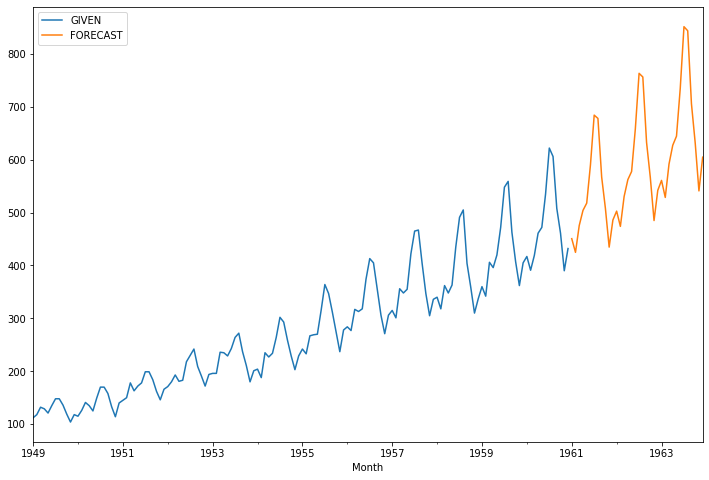

In [16]:
passenger_data['Thousands of Passengers'].plot(legend=True, label='GIVEN', figsize=(12, 8))
forecast_predictions.plot(legend=True, label='FORECAST', figsize=(12, 8))

Time series dataset is stationary if it does not exhibit trends or seasonality

In [17]:
samples_data = pd.read_csv('/content/samples.csv', index_col=0, parse_dates=True)

In [18]:
samples_data.head()

,a,b,c,d
1950-01-01,36,27,0,67
1950-02-01,58,22,3,31
1950-03-01,61,17,5,67
1950-04-01,37,15,8,47
1950-05-01,66,13,8,62


No obvious trends or repetition; stationary dataset

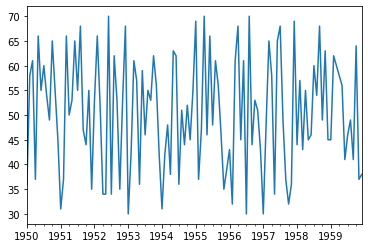

In [19]:
samples_data['a'].plot()

Obvious linear trend upwards, non-stationary dataset

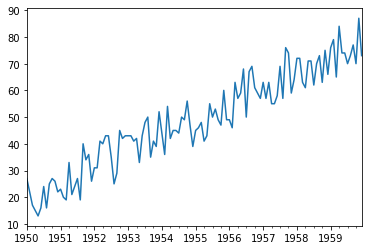

In [20]:
samples_data['b'].plot()

Apply differencing to make non-stationary data stationary by subtracting adjacent time steps

In [21]:
from statsmodels.tsa.statespace.tools import diff

Overview of differencing operation performed by shifting data points to subtract adjacent time steps. First-order difference; can perform n-th order difference. Each order of differencing corresponds to type of underlying trend removed meaning first-order difference for linear trend, second-order for quadratic trend, etc.

In [22]:
samples_data['b'] - samples_data['b'].shift(1)

1950-01-01     NaN
1950-02-01    -5.0
1950-03-01    -5.0
1950-04-01    -2.0
1950-05-01    -2.0
              ... 
1959-08-01     3.0
1959-09-01     4.0
1959-10-01    -7.0
1959-11-01    17.0
1959-12-01   -14.0
Name: b, Length: 120, dtype: float64

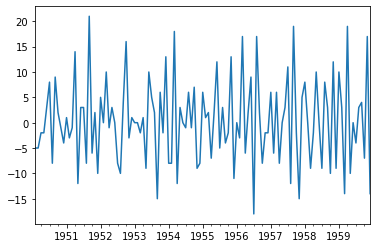

In [23]:
diff(samples_data['b'], k_diff=1).plot()

In [24]:
import statsmodels.api as sm

In [25]:
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols

In [26]:
# NON-STATIONARY
passenger_data.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [27]:
# STATIONARY
birthdata = pd.read_csv('/content/DailyTotalFemaleBirths.csv', index_col='Date', parse_dates=True)
birthdata.index.freq = 'D'

In [28]:
birthdata.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [29]:
from pandas.plotting import lag_plot

Correlation exists between current and lagged time steps, autoregressive behavior indicative

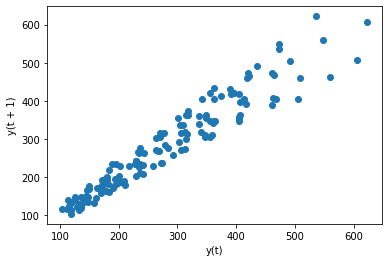

In [30]:
lag_plot(passenger_data['Thousands of Passengers'])

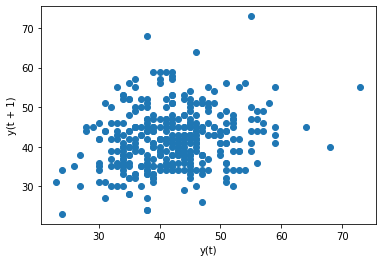

In [31]:
lag_plot(birthdata['Births'])

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Peaks indicate seasonality in data, shaded region is 95% confidence interval (CI) suggesting correlation values outside of CI are highly correlated with greater certainty

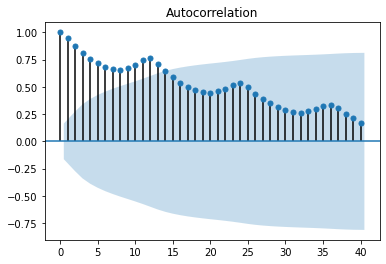

In [33]:
plot_acf(passenger_data['Thousands of Passengers'], lags=40);

Sharp drop-off in stationary dataset, no autoregressive behavior

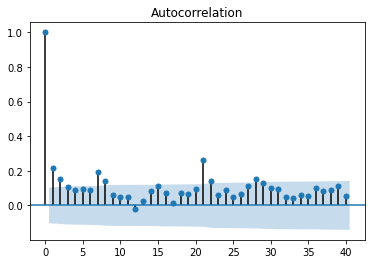

In [34]:
plot_acf(birthdata, lags=40);

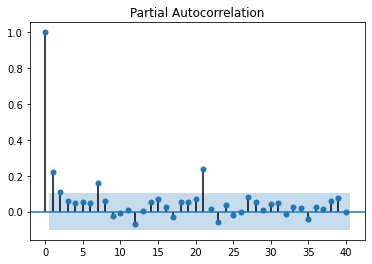

In [35]:
plot_pacf(birthdata, lags=40);

ARIMA(p, d, q) defined by components where p indicates relation between current and past observations (AR), d indicates differencing of observations to make data stationary (I), q indicates dependency between observation and residual error from a moving average model (MA) applied to lagged observations. Where a stationary time series has constant mean and variance over time.

Can apply augmented dickey-fuller test (ADF) to test for data stationarity 

To choose p, d, q terms, can either use autocorrelation & partial autocorrelation plots (difficult to read), or run a grid search by trying different ARIMA models on variations of p, d, q and comparing them on some evaluation metric. Latter method much easier, more accurate given computational power

For autoregressive models, assume current time term depends on previous time term plus some stochastic (noise) term. AR models are a subset of ARIMA models which are a subset of Vector Autoregressive Models (VAR) 

In [36]:
from statsmodels.tsa.ar_model import AR, ARResults

In [37]:
pop_data = pd.read_csv('/content/uspopulation.csv', index_col='DATE', parse_dates=True)

In [38]:
pop_data.index.freq = 'MS'
pop_data.head()

,PopEst
DATE,
2011-01-01,311037
2011-02-01,311189
2011-03-01,311351
2011-04-01,311522
2011-05-01,311699


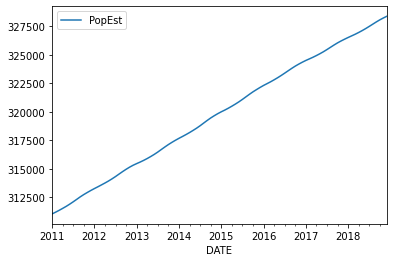

In [39]:
pop_data.plot()

In [40]:
train = pop_data.iloc[:84]
test = pop_data.iloc[84:]

In [41]:
model = AR(train['PopEst'])
AR1fit = model.fit(maxlag=1)

In [42]:
AR1fit.params

const        284.913797
L1.PopEst      0.999686
dtype: float64

In [43]:
start = len(train)
end = len(train) + len(test) - 1

In [44]:
predictions = AR1fit.predict(start, end)
predictions = predictions.rename('AR(1) Predictions')

In [45]:
AR2fit = model.fit(maxlag=2)

In [46]:
AR2fit.params

const        137.368305
L1.PopEst      1.853490
L2.PopEst     -0.853836
dtype: float64

In [47]:
predictions2 = AR2fit.predict(start=start, end=end)
predictions2 = predictions2.rename('AR(2) Predictions')

Allow statsmodels to select AR with best lag by not setting a max-lag; statsmodels then uses selected criterion to evaluate model fit (where criterion are: AIC, BIC, T-stat). Criterion used for model selection.

In [48]:
ARfit = model.fit(ic='t-stat')

In [49]:
predictions8 = ARfit.predict(start, end)
predictions8 = predictions8.rename('AR(8) Predictions')

In [50]:
ARfit.params

const        82.309677
L1.PopEst     2.437997
L2.PopEst    -2.302100
L3.PopEst     1.565427
L4.PopEst    -1.431211
L5.PopEst     1.125022
L6.PopEst    -0.919494
L7.PopEst     0.963694
L8.PopEst    -0.439511
dtype: float64

In [51]:
from sklearn.metrics import mean_squared_error
labels = ['AR1', 'AR2', 'AR8']

In [52]:
preds = [predictions, predictions2, predictions8]

Compare model fit on test set for all models using MSE

In [53]:
for i in range(len(preds)):
  error = mean_squared_error(test['PopEst'], preds[i])
  print(f'{labels[i]} MSE was: {error}')

AR1 MSE was: 17449.714242014332
AR2 MSE was: 2713.258895540958
AR8 MSE was: 186.97809636815634


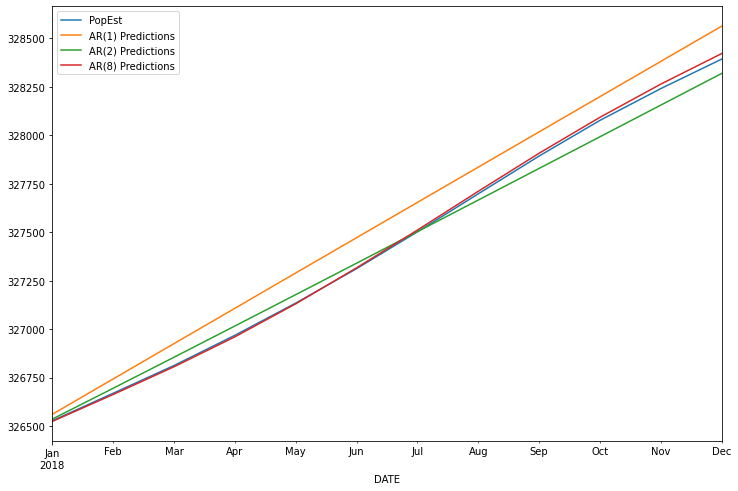

In [54]:
test.plot(figsize=(12, 8), legend=True)
predictions.plot(legend=True)
predictions2.plot(legend=True)
predictions8.plot(legend=True)

Retrain model on entire dataset, then forecast 12 months into future

In [55]:
model = AR(pop_data['PopEst'])
ARfit = model.fit()
forecasted_predictions = ARfit.predict(start=len(pop_data), end=len(pop_data)+12).rename('Forecast')

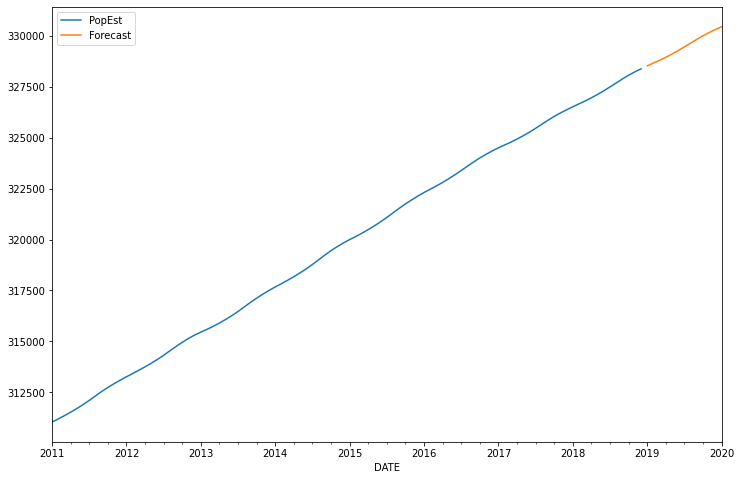

In [57]:
pop_data['PopEst'].plot(figsize=(12, 8), legend=True)
forecasted_predictions.plot(legend=True)